In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
X = np.load('x_digits.npy')
Y = np.load('y_digits.npy')

In [3]:
X[0].shape, Y.shape

((129, 71), (35631,))

There are 35 thousand 'pictures' (observations) representing numbers from 0 to 9. Each number has 129 rows with 71 columns. (maybe, maybe not, check again)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape([-1, 129, 71, 1])
X_test = X_test.reshape([-1, 129, 71, 1])


We split the data in train and test sets as we will use the built-in split from tensorflow when training the neural network.

In [5]:
X_train[1].shape

(129, 71, 1)

### Take 1:
We start of with a small neural network, keeping the size of the feature maps relavtively small. As advised we use the ReLu activation function. The size of the feature map is 3 x 3. We also use EarlyStopping callback and Learning Rate callback.

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(X_train[0].shape))
model.add(tf.keras.layers.Conv2D(8, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

EarlyStoppingCB = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = "True")
LearningRateCB = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 2)

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.002)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(X_train, Y_train, epochs = 30, validation_split=0.2, callbacks = [EarlyStoppingCB, LearningRateCB])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2032 - loss: 2.6165 - val_accuracy: 0.7469 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8054 - loss: 0.5931 - val_accuracy: 0.8755 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9057 - loss: 0.2934 - val_accuracy: 0.9049 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9406 - loss: 0.1916 - val_accuracy: 0.9177 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9541 - loss: 0.1380 - val_accuracy: 0.9097 - val_loss: 0.2942 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9668 - loss: 0.0977 - val_accuracy: 0.9219 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9821 - loss: 0.0565 - 

In [7]:
print("Loss + accuracy on train data: {}".format(model.evaluate(X_train, Y_train)))
print("Loss + accuracy on test data: {}".format(model.evaluate(X_test, Y_test)))

891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9870 - loss: 0.0441
Loss + accuracy on train data: [0.08068317174911499, 0.9781083464622498]
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9363 - loss: 0.2480
Loss + accuracy on test data: [0.26097607612609863, 0.9326505064964294]


In [8]:
single_example = X_test[0]  # Example, take the first sample from the test set
single_example = single_example.reshape(129, 71, 1)  # Reshape to (129, 71, 1)

# Expand dimensions to make it a batch of size 1 (shape becomes (1, 129, 71, 1))
single_example = np.expand_dims(single_example, axis=0)

# Make a prediction
prediction = model.predict(single_example)

# Print the prediction (depending on your output layer, this could be probabilities or class labels)
prediction, Y_test[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


(array([[2.8899146e-17, 1.0556056e-09, 1.2023184e-12, 3.7718140e-09,
         1.8542904e-08, 9.9999821e-01, 7.2123491e-10, 1.7413884e-06,
         5.3675550e-11, 6.6391990e-09]], dtype=float32),
 5.0)

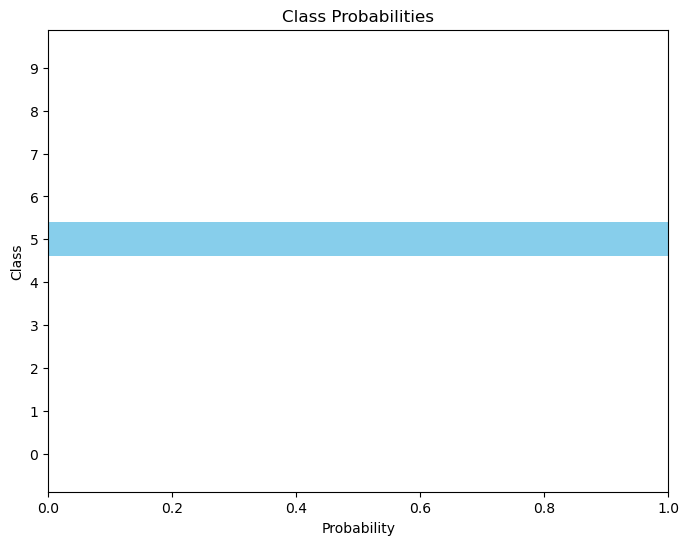

In [9]:
classes = np.arange(10)

probabilities = prediction.flatten()
# Create a horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(classes, probabilities, color='skyblue')
plt.yticks(classes)
plt.xlabel('Probability')
plt.ylabel('Class')
plt.title('Class Probabilities')
plt.xlim(0, 1)  # Since it's a probability, we limit the x-axis to [0, 1]

# Show the plot
plt.show()

Seems like the model was very confident that this recording represented a 5. Let's see a case where the probability was less than 50%:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

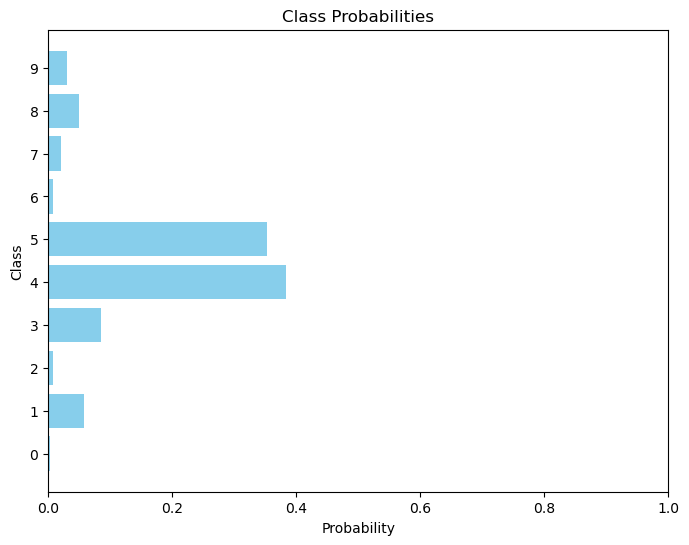

In [19]:
threshold = 0.5 
for i in range(len(X_test)):
    single_example = X_test[i].reshape(129, 71, 1)  # Reshape each example
    single_example = np.expand_dims(single_example, axis=0)  
    
    prediction = model.predict(single_example)  # Get prediction
    max_prob = np.max(prediction)  
    
    if max_prob < threshold:  
        print(f"Prediction found with confidence less than {threshold*100}% for index {i}")
        print(f"Predicted probabilities: {prediction}")
        print(f"True label: {Y_test[i]}")

        # Plot the probabilities for this prediction
        probabilities = prediction.flatten()
        plt.figure(figsize=(8, 6))
        plt.barh(classes, probabilities, color='skyblue')
        plt.yticks(classes)
        plt.xlabel('Probability')
        plt.ylabel('Class')
        plt.title('Class Probabilities')
        plt.xlim(0, 1)  # Since it's a probability, we limit the x-axis to [0, 1]
        
        plt.show()

        break  

Here, the model predicted a 38% chance for a 4, and a 35% chance for a 5. This could potentially be a pair the model finds difficult? Let's investigate a case where the probability was less than 30%. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

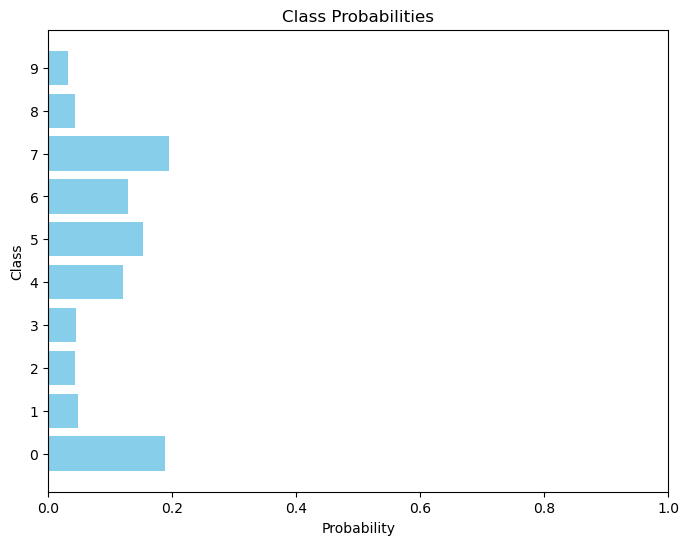

In [16]:
threshold = 0.3 
for i in range(len(X_test)):
    single_example = X_test[i].reshape(129, 71, 1)  
    single_example = np.expand_dims(single_example, axis=0) 
    
    prediction = model.predict(single_example) 
    max_prob = np.max(prediction) 
    
    if max_prob < threshold: 
        print(f"Prediction found with confidence less than {threshold*100}% for index {i}")
        print(f"Predicted probabilities: {prediction}")
        print(f"True label: {Y_test[i]}")

       
        probabilities = prediction.flatten()
        plt.figure(figsize=(8, 6))
        plt.barh(classes, probabilities, color='skyblue')
        plt.yticks(classes)
        plt.xlabel('Probability')
        plt.ylabel('Class')
        plt.title('Class Probabilities')
        plt.xlim(0, 1)  
        
        plt.show()

        break  

In this case, the maximum confidence is 19.5% for 7. The model is almost equally uncertain between 7, 0 and 5. Let's see what are the pairs that the model confuses most often: 

In [20]:
from collections import Counter

threshold = 0.5

# Dictionary to count how often each digit is predicted with low confidence
struggling_digits = Counter()

struggling_pairs = Counter()

# Iterate through predictions and corresponding true labels
for probs, true_label in zip(model.predict(X_train), Y_train):
    predicted_label = np.argmax(probs)  # Get the predicted class (class with highest probability)
    max_prob = np.max(probs)  # Get the highest probability

    # If the model is uncertain or if the prediction is incorrect
    if max_prob < threshold or predicted_label != true_label:
        struggling_pairs[(true_label, predicted_label)] += 1  # Count the true-predicted pair

# Output the struggling digit pairs (true label, predicted label)
print("Struggling digit pairs (True Label, Predicted Label):", struggling_pairs)

891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Struggling digit pairs (True Label, Predicted Label): Counter({(6.0, 7): 34, (4.0, 5): 27, (9.0, 5): 25, (0.0, 2): 25, (5.0, 7): 22, (8.0, 6): 22, (8.0, 3): 20, (0.0, 7): 20, (4.0, 7): 18, (9.0, 1): 17, (1.0, 9): 17, (1.0, 5): 16, (2.0, 7): 15, (3.0, 2): 15, (3.0, 8): 15, (5.0, 9): 15, (7.0, 2): 15, (2.0, 2): 14, (2.0, 0): 14, (6.0, 6): 13, (4.0, 2): 13, (8.0, 8): 13, (8.0, 2): 13, (1.0, 1): 12, (1.0, 4): 12, (9.0, 7): 11, (4.0, 1): 11, (3.0, 3): 11, (2.0, 4): 11, (3.0, 7): 10, (4.0, 4): 9, (3.0, 5): 9, (2.0, 3): 9, (3.0, 6): 9, (7.0, 5): 8, (9.0, 9): 7, (5.0, 5): 7, (9.0, 0): 7, (1.0, 7): 7, (8.0, 5): 7, (6.0, 8): 7, (6.0, 3): 7, (5.0, 4): 6, (6.0, 0): 6, (5.0, 3): 6, (7.0, 7): 6, (2.0, 8): 6, (6.0, 2): 5, (7.0, 6): 5, (8.0, 9): 5, (5.0, 1): 5, (0.0, 0): 4, (6.0, 5): 4, (3.0, 9): 4, (7.0, 0): 4, (8.0, 0): 3, (9.0, 4): 3, (0.0, 6): 3, (3.0, 0): 3, (1.0, 6): 3, (9.0, 2): 3, (7.0, 4): 3, (4.0, 6): 3, (1.0, 2): 3, (3.0, 4): 3, (0.0, 3): 2, (4.0, 8)

In [11]:
predictions = model.predict(X_train)

891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


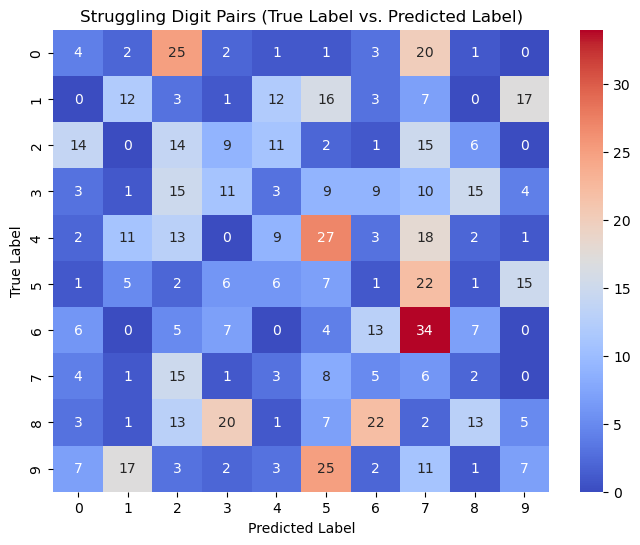

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

threshold = 0.5

# Dictionary to count the struggling pairs (true_label, predicted_label)
struggling_pairs = Counter()

# Iterate through predictions and corresponding true labels
for probs, true_label in zip(predictions, Y_train):
    predicted_label = np.argmax(probs)  # Get the predicted class (class with highest probability)
    max_prob = np.max(probs)  # Get the highest probability
    # If the model is uncertain or if the prediction is incorrect
    if max_prob < threshold or predicted_label != true_label:
        struggling_pairs[(int(true_label), int(predicted_label))] += 1  # Count the true-predicted pair

# Initialize a confusion matrix (10x10 since we have digits 0-9)
confusion_matrix = np.zeros((10, 10))

# Populate the confusion matrix with the struggling pairs
for (true_label, predicted_label), count in struggling_pairs.items():
    confusion_matrix[true_label, predicted_label] = count

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Struggling Digit Pairs (True Label vs. Predicted Label)')
plt.show()

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(X_train[0].shape))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = "relu", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

EarlyStoppingCB = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = "True")
LearningRateCB = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 1)

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.005)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(X_train, Y_train, epochs = 30, validation_split=0.2, callbacks = [EarlyStoppingCB, LearningRateCB])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 148s 202ms/step - accuracy: 0.4459 - loss: 3.3447 - val_accuracy: 0.9026 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.9179 - loss: 0.2596 - val_accuracy: 0.9176 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 145s 203ms/step - accuracy: 0.9513 - loss: 0.1504 - val_accuracy: 0.9354 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 150s 211ms/step - accuracy: 0.9630 - loss: 0.1121 - val_accuracy: 0.9279 - val_loss: 0.2077 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 144s 202ms/step - accuracy: 0.9828 - loss: 0.0533 - val_accuracy: 0.9472 - val_loss: 0.1909 - learning_rate: 5.0000e-04
Epoch 6/30
185/713 ━━━━━━━━━━━━━━━━━━━━ 1:40 190ms/step - accuracy: 0.9898 - loss: 0.0329

KeyboardInterrupt: 

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2751 - loss: 6.7857 - val_accuracy: 0.3643 - val_loss: 2.3307 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4323 - loss: 2.0958 - val_accuracy: 0.5243 - val_loss: 1.6699 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5302 - loss: 1.6069 - val_accuracy: 0.5185 - val_loss: 1.6058 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5681 - loss: 1.4307 - val_accuracy: 0.6060 - val_loss: 1.3237 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6070 - loss: 1.2590 - val_accuracy: 0.5980 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6384 - loss: 1.1299 - val_accuracy: 0.6201 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6465 - loss: 1.1671 - 

Well this works okay, the validation accuracy is not perfect, but it's satisfying. Let's try with swish activation function.

In [34]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2560 - loss: 5.7668 - val_accuracy: 0.4313 - val_loss: 2.0350 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4197 - loss: 2.0398 - val_accuracy: 0.4654 - val_loss: 1.7794 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5057 - loss: 1.6367 - val_accuracy: 0.5590 - val_loss: 1.4783 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5581 - loss: 1.3812 - val_accuracy: 0.5424 - val_loss: 1.4503 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5839 - loss: 1.2322 - val_accuracy: 0.6027 - val_loss: 1.1591 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6182 - loss: 1.1189 - val_accuracy: 0.6308 - val_loss: 1.0953 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6409 - loss: 1.0729 - 

Okay so changing to swish activation function doesn't change anything. Let's move back to the ReLu and increase the number of neurons.

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(300, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(200, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3111 - loss: 10.0604 - val_accuracy: 0.5034 - val_loss: 1.7093 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5414 - loss: 1.7691 - val_accuracy: 0.6476 - val_loss: 1.2296 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6448 - loss: 1.2819 - val_accuracy: 0.6769 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6993 - loss: 1.0510 - val_accuracy: 0.7043 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7346 - loss: 0.8924 - val_accuracy: 0.7179 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7602 - loss: 0.8421 - val_accuracy: 0.7485 - val_loss: 0.8364 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7875 - 

Nice! The train accuracy reached a whopping 97%, unfortunately, the validation accuracy is 10 percent points less, which is an unacceptable proof of overfitting. Therefore, we will try to change the optimizer to AdamW to introduce weight_decay and regularization. Let's start with weight decay = 0.0075

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = [129, 71]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(300, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(200, activation = "relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay=0.0075)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler= tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 2)
history = model.fit(X_train, Y_train, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_cb, lr_scheduler])

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.2981 - loss: 10.5311 - val_accuracy: 0.5232 - val_loss: 1.6547 - learning_rate: 0.0010
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5555 - loss: 1.6789 - val_accuracy: 0.6078 - val_loss: 1.2272 - learning_rate: 0.0010
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6543 - loss: 1.1291 - val_accuracy: 0.6881 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7051 - loss: 0.9096 - val_accuracy: 0.7465 - val_loss: 0.7937 - learning_rate: 0.0010
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7320 - loss: 0.8024 - val_accuracy: 0.7374 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7706 - loss: 0.6918 - val_accuracy: 0.7362 - val_loss: 0.8411 - learning_rate: 0.0010
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8288 - 

Hmm that doesn't seem like a lot of help, let's try reducing the number of neurons and add more layers... but that will come in the next episode!